In [1]:
#
#official package
#
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import Generator, MT19937
from sklearn.metrics import mean_squared_error

#
# lorenz 96 model by fortran
#
"""
f2py -c -m fortran_model model_time_step.f90で共有ファイル(.so)を作成
Fortran プログラムを Pythonで利用する
(python version 3.8)
"""
import fortran_model as FModel

### Fmodel の引数の確認

In [2]:
print(FModel.lorenz_model.__doc__)

'd'-scalar
'd'-scalar
p_out = model_right_term(p_in,[n])

Wrapper for ``model_right_term``.

Parameters
----------
p_in : input rank-1 array('d') with bounds (n)

Other Parameters
----------------
n : input int, optional
    Default: len(p_in)

Returns
-------
p_out : rank-1 array('d') with bounds (n)
x_out = runge_kutta_method(x_in,[n])

Wrapper for ``runge_kutta_method``.

Parameters
----------
x_in : input rank-1 array('d') with bounds (n)

Other Parameters
----------------
n : input int, optional
    Default: len(x_in)

Returns
-------
x_out : rank-1 array('d') with bounds (n)
mm = kf_matrix_get_m(x_init,t_step,alpha,[n])

Wrapper for ``kf_matrix_get_m``.

Parameters
----------
x_init : input rank-1 array('d') with bounds (n)
t_step : input int
alpha : input float

Other Parameters
----------------
n : input int, optional
    Default: len(x_init)

Returns
-------
mm : rank-2 array('d') with bounds (n,n)



## Lorenz 96 model
- NN: 変数ベクトルXの次元 (通常40)
- FF: 外力
- dt: モデルの１積分時間

FF, dt はFortranプログラムの中で定義されており書き換えはできないことに注意

In [3]:
#
#モデルの変数
#
NN = 40
FF = 8.0
dt = 0.01

#
#時間単位
#
"""
tstep_1d: 1日の積分回数
tstep_1y: 1年の積分回数
"""
tstep_1d = int(0.2/dt)
tstep_1y = int(365*tstep_1d)
print("time step 1day:{}".format(tstep_1d))
print("time step 1year:{}".format(tstep_1y))
print()

#
#初期値
#
XX_IN = np.ones(NN, dtype=np.float64)*FF
XX_IN[19] = FF + FF/1000
print("初期値 X0 =\n{}".format(XX_IN))
print()

#
#作業変数
#
XX_OUT = np.zeros_like(XX_IN, dtype=np.float64)

#
#時間発展 1年間
#
for idx_time in range(tstep_1y):
    XX_OUT = FModel.lorenz_model.runge_kutta_method(XX_IN,NN)
    XX_IN = XX_OUT
print("XX =\n{}".format(XX_IN))

time step 1day:20
time step 1year:7300

初期値 X0 =
[8.    8.    8.    8.    8.    8.    8.    8.    8.    8.    8.    8.
 8.    8.    8.    8.    8.    8.    8.    8.008 8.    8.    8.    8.
 8.    8.    8.    8.    8.    8.    8.    8.    8.    8.    8.    8.
 8.    8.    8.    8.   ]

XX =
[-3.90380328  1.7487763   3.60908351  4.84378415  2.06333088 -2.97072136
  1.80892982  4.36721546  5.91411737 -3.94056404 -1.21157625  1.51993115
  1.98580203  9.111064    1.97504058 -3.45502749  1.67867415  2.1374675
  6.59182148 -3.00876163 -2.35779272 -3.67688229  3.98047531  8.21987869
 -0.94703903  4.53089987  1.24828117 -0.39319517  1.41696151  9.06749876
  0.81474818 -4.42618128  0.45601611  3.23908588  7.38666433 -0.24708298
 -1.65579636  2.40499248  8.01116961  1.01051069]


### データ同化のパラメータ
- tstep_assim: データ同化のステップ間隔
- alpha_m:     接線形モデルを計算する際のパラメータ
- alpha:       共分散膨張係数
- sigma_obs:   観測誤差
- RR:          観測誤差共分散行列
- PA:          解析誤差共分散行列
- PF:          予報誤差共分散行列
- HH:          観測モデル
- XF:          予報値
- XA:          解析値
- XT:          真析値
- YY:          観測値

In [11]:
assim_step = 5
alpha_m = 1e-5
alpha = 1.5
sigma_obs = 1.0

RR = sigma_obs*np.eye(NN)
PA = 100*np.eye(NN)
PF = np.empty_like(PA)
HH = np.eye(NN)

XA = XX_IN + np.random.normal(0,10,NN)
XT = XX_IN

### データ同化の実行

In [12]:
j = 0
XF_LOG = []
XA_LOG = []
XT_LOG = []
YY_LOG = []
TRACE_PA = []
TRACE_PF = []
RMSE_XA = []
CYCLE = []


RR = sigma_obs*np.eye(NN)
PA = 100*np.eye(NN)
PF = np.empty_like(PA)
HH = np.eye(NN)
XA = XX_IN + np.random.normal(0,10,NN)
XT = XX_IN


for idx_assim in range(500):
    #
    #予報値の初期値
    #
    XF = XA
    #
    #予報値の時間発展
    #
    for idx_time in range(assim_step):
        XF = FModel.lorenz_model.runge_kutta_method(XF,NN)
    #
    #真値の時間発展
    #
    for idx_time in range(assim_step):
        XT = FModel.lorenz_model.runge_kutta_method(XT,NN)
    #
    #観測値
    #
    YY = XT + np.random.normal(0,sigma_obs,NN)
    #
    #接線形行列Mの計算
    #
    MM = FModel.lorenz_model.kf_matrix_get_m(XA, assim_step, alpha_m)
    #
    #予報誤差共分散行列
    #
    PF = MM * PA * MM.T
    #
    #共分散膨張
    #
    PF = alpha * PF
    #
    #カルマンゲイン
    #
    TMP = HH * PF * HH.T + RR
    KK = PF * HH.T * np.linalg.inv(TMP)
    #
    #解析値
    #
    XA = XF + KK @ ( YY - HH @ XF )
    #
    #解析誤差共分散行列
    #
    PA = PF - KK * HH * PF
    
    #
    #記録
    #
    XF_LOG.append(XF[j])
    XA_LOG.append(XA[j])
    XT_LOG.append(XT[j])
    YY_LOG.append(YY[j])
    RMSE_XA.append(np.sqrt(mean_squared_error(XA, XT)))
    TRACE_PA.append(np.sqrt(np.trace(PA)/NN))
    TRACE_PF.append(np.sqrt(np.trace(PF)/NN))
    CYCLE.append(idx_assim)

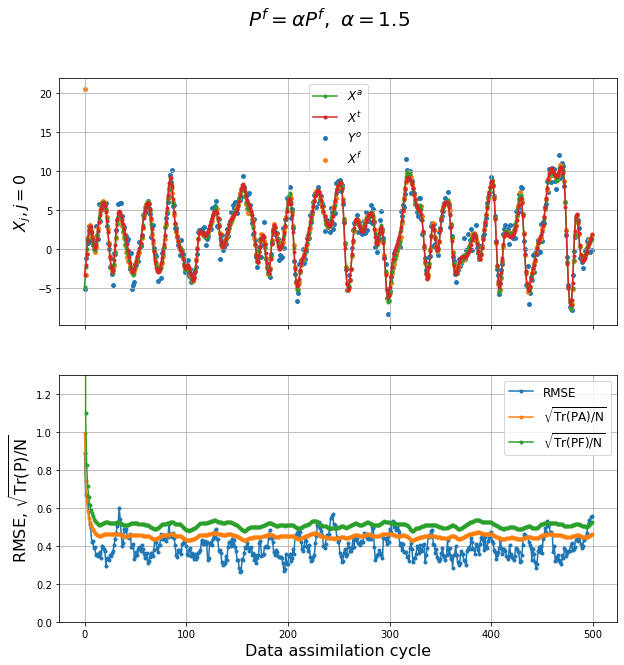

In [13]:
#
#graphic paraemeter
#
cmap = plt.get_cmap("tab10")
fs = 16
msize = 15

#
#figure
#
fig, ax = plt.subplots(2,1,figsize=(10,10),sharex=True)
fig.suptitle("$P^f = \\alpha P^f, \ \\alpha=${}".format(alpha), fontsize=fs+4)

ax[0].scatter(CYCLE, YY_LOG, color=cmap(0), label="$Y^o$", s=msize)
ax[0].scatter(CYCLE, XF_LOG, color=cmap(1), label="$X^f$", s=msize)
ax[0].plot(CYCLE, XA_LOG, color=cmap(2), label="$X^a$", marker='.')
ax[0].plot(CYCLE, XT_LOG, color=cmap(3), label="$X^t$", marker='.')
ax[0].set_ylabel("$X_j, j=${}".format(j), fontsize=fs)
ax[0].grid(True)
ax[0].legend(fontsize=fs-4)

ax[1].plot(CYCLE, RMSE_XA, label="RMSE", marker='.')
ax[1].plot(CYCLE, TRACE_PA, label="$\\sqrt{\mathrm{Tr(PA)/N}}$", marker='.')
ax[1].plot(CYCLE, TRACE_PF, label="$\\sqrt{\mathrm{Tr(PF)/N}}$", marker='.')
ax[1].set_xlabel("Data assimilation cycle", fontsize=fs)
ax[1].set_ylabel("RMSE, $\\sqrt{\mathrm{Tr(P)/N}}$", fontsize=fs)
ax[1].set_ylim(0,1.3)
ax[1].grid()
ax[1].legend(fontsize=fs-4)

plt.show()